Testing biological calibration of the Salish Sea Atlantis Model

In [2]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
from mpl_toolkits.axes_grid1 import make_axes_locatable

The best calibration for both diatom and zooplankton spatial distribution and biomass is
- v6719_50y_VBITBUCKET-mumVERT-ddmove0-2-ZGppreyW_Sharks1

This could be used for the Turn Point spill in the event that other calibrations do not work. This calibration is missing long-term biomass for the following:
- small pelagic fish (FDS)
- small demersal fish (FDL)
- prawns (PWN)
- carniv zoo (ZL)
- squid (CEP)

Turning on ddepend_move for FDS, FDL, CEP and ZL leads to improvements in all their biomass and distribution, but brings down the biomass for diatoms, making it effectively 0 in certain boxes. This is evident in run:
- v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1

Turning on ddepend_move for PWN leads to exceedingly high PWN biomass, which crashes the model after a short time with a Ref_Det flux error. 

Reducing predation on diatoms results in their increased biomass when ddepend_move is on for FDS, FDL, CEP and ZL, as seen in the results of this run. 
- v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL

In this run, once fishing has been turned on, only large flatfish (FFL), PWN, CEP and ZL do not maintain biomass for a 50-year run. See
- v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing

In [3]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/')
scenario_paths = sorted([p for p in scenario_root.glob('v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing/outputSalishSea.nc')])
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)
    print(path.parent.stem)

v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing


In [4]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [5]:
strait_of_georgia = [54,64,68,79,62,80,81,82,83,84,85,86,88,90,91,92,94,96,98,101,102]
sog_south = [54,64,68,79]
sog_center = [62,80,81,82,83,84,85]
sog_north = [86,88,90,91,92,94,96,98,101,102]
puget_sound_main = [20,21,23,26]
fraser_river_plume = [75,80,81]

In [6]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
sog_s_df = data_df.loc[sog_south]
sog_c_df = data_df.loc[sog_center]
sog_n_df = data_df.loc[sog_north]
ps_df = data_df.loc[data_df.Region=='Puget Sound']
fr_df = data_df.loc[fraser_river_plume]

In [7]:
spillbox = [33]
spill_df = data_df.loc[spillbox]

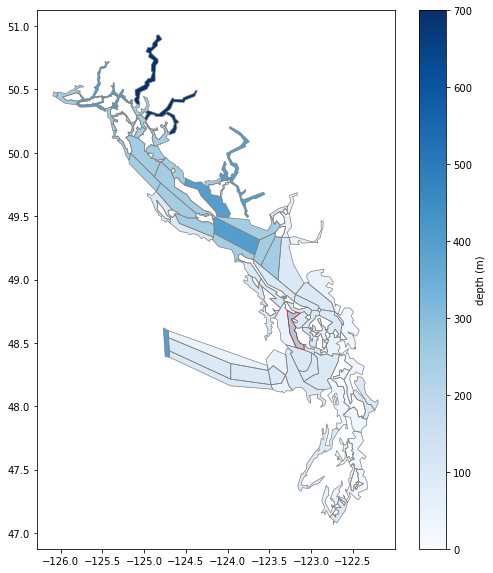

In [8]:
# Location Map
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'BOTZ', ax=ax, cax=cax,cmap=cm.Blues,
    legend=True, legend_kwds={'label': 'depth (m)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
spill_df.boundary.plot(ax=ax, color='red',linewidths=0.5)
#ps_df.boundary.plot(ax=ax, color='red');
#fr_df.boundary.plot(ax=ax, color='orange');
land_df.plot(ax=ax, color='white');

# Diatoms Biomass Comparisons

### Atlantis Model for Puget Sound (AMPS) Data

In [9]:
# Extracting AMPS diatom data
amps_filename = "AMPS_OUT_7.nc"
amps_data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/" + amps_filename
amps_data = xr.open_dataset(str(amps_data_file), decode_cf=True) #[t, box, z]

amps_time = amps_data.t
amps_volume = amps_data.volume
diatoms_amps_tbz = amps_data.Lrg_Phyto_N * amps_volume #convert to mg N 
diatoms_amps_tb = diatoms_amps_tbz[:,:,0:6].sum(axis=2)
diatoms_amps_t = diatoms_amps_tb.sum(axis=1) #* 1e-9 # convert from mg N to tonnes

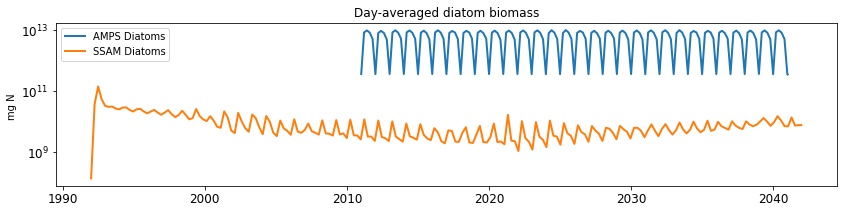

In [10]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(amps_time, diatoms_amps_t, linewidth = 2) #semilogy
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('mg N ')
ax.tick_params(labelsize=12)
for scenario in scenario_datasets:
    var_tbl = scenario.Diatom_N[:,puget_sound_main,0:6] * scenario.volume[:,puget_sound_main,0:6]
    var_tb = var_tbl.sum(axis=2)
    ax.semilogy(scenario.t, var_tb.mean(axis=1), linewidth = 2) 
ax.legend(['AMPS Diatoms','SSAM Diatoms'], loc='best');

### SalishSeaCast Data

# SalishSeaCast daily averaged diatom data for 30 days in 2007
ssc_data = xr.open_dataset('/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_compressed_20070101_20070131.nc')
mesh = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')

ssc_volume = (mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})
diatoms_SSC_tzyx = ssc_data.diatoms # [t,z,y,x]
diatoms_SSC_tzyx = diatoms_SSC_tzyx * ssc_volume # convert from mmol m-3 to mmol
# Convert mmol N * 14.0067 mg/mmol 
diatoms_SSC_tzy = diatoms_SSC_tzyx.sum(axis=3)
diatoms_SSC_tz = diatoms_SSC_tzy.sum(axis=2)
diatoms_SSC_t = diatoms_SSC_tz.sum(axis=1) * (14.0067) #convert to mg N

fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(ssc_data.time, diatoms_SSC_t, 'k.', linewidth = 2) #semilogy
#ax.plot(ssam_time[5:37], diatoms_SSAM_t[5:37],'b.', linewidth = 2)
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('mg N')
ax.tick_params(labelsize=12)
ax.legend(['SSC diatoms'], loc='best'); #'SSAM diatoms'

### SSAM Data

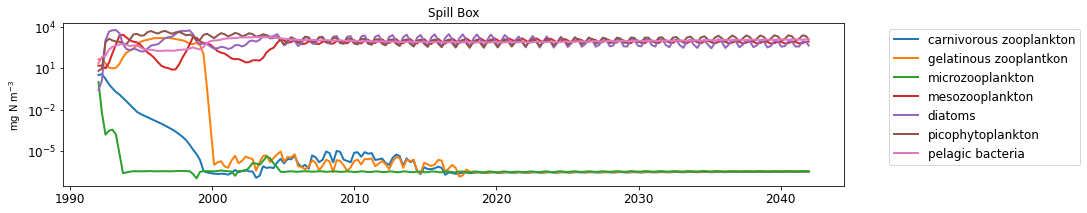

In [11]:
group = groups.plankton
fig, ax = plt.subplots(figsize = (14,3)) 
labels = []

for scenario in scenario_datasets:
    for species in group:
        spp_name = str(group[species]) + '_N'
        var_tbl = scenario.variables[group[species] + '_N'][:,spillbox,0:6]
        var_tb = var_tbl.sum(axis=2)
        ax.semilogy(scenario.t, var_tb.mean(axis=1), linewidth = 2) 
        #ax.semilogy(scenario.t, scenario.Diatom_N[:,strait_of_georgia,0:6].mean(axis=1), linewidth = 2) #semilogy
        labels.append(species)
        ax.set_title('Spill Box', fontsize = 12)
        ax.set_ylabel('mg N m$^{-3}$')
        ax.tick_params(labelsize=12)
    #ax.legend(labels, fontsize = 12,loc='upper left');
    ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

# Maps

### Surface values

In [12]:
def map_surface(group, v_max=None, v_min=None):
  
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, height_ratios=[3, 3, 3])

    for scenario, label in zip(scenario_datasets, scenario_labels):

        for species in group:

            b_index = (list(group).index(species))

            if b_index < 3:
                position = 0, b_index
            elif b_index > 5: 
                position = 2, b_index-6
            else :
                position = 1, b_index-3

            scen_tb = scenario.variables[group[species] + '_N'][len(scenario.t)-5:len(scenario.t),:,5]
            scen = scen_tb.mean(axis=0)
            nm = str(label).split(sep = '_')

            data_df['scen'] = scen
            data_df.loc[land_boxes, 'scen'] = 0

            ax = fig.add_subplot(gs[position])
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=-0.5) 
            ax = data_df.plot(column = 'scen', ax=ax, vmin=v_min, vmax=v_max, cax=cax, #norm=colors.LogNorm(vmin=1, vmax=data_df.old_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
                legend=True, legend_kwds={'label': species + ' (mg N m$^{-3}$)'},
                )
            ax.set_title(species, fontsize = 12)
            data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
            land_df.plot(ax=ax, color='white');

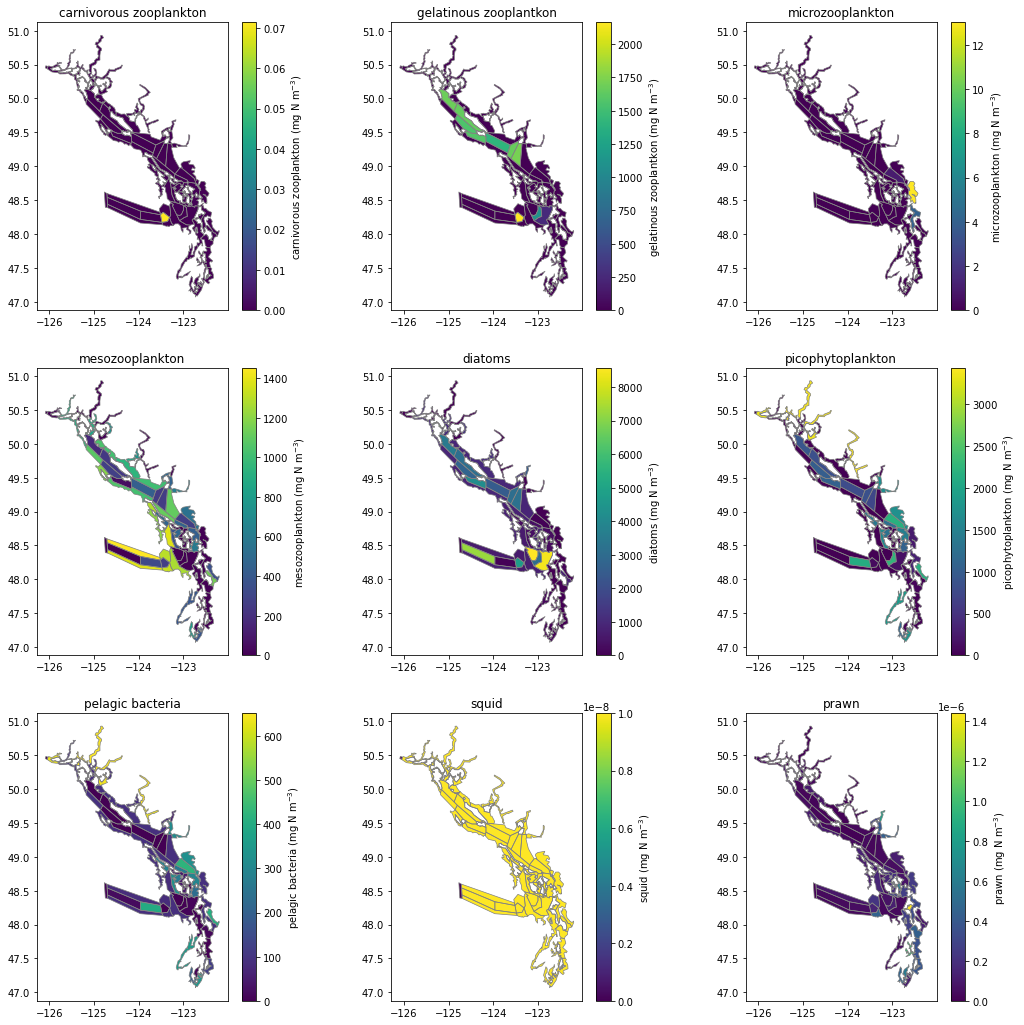

In [13]:
map_surface(groups.planktonic)

### Water column

In [14]:
def map_water_column(group):
  
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, height_ratios=[3, 3, 3])

    for scenario, label in zip(scenario_datasets, scenario_labels):

        for species in group:

            b_index = (list(group).index(species))

            if b_index < 3:
                position = 0, b_index
            elif b_index > 5: 
                position = 2, b_index-6
            else :
                position = 1, b_index-3

            nm = str(label).split(sep = '_')
            dVar_s = scenario.variables[group[species] + '_N'][len(scenario.t)-5:len(scenario.t),:,0:6]
            scen_tb = dVar_s.sum(axis=2)
            scen = scen_tb.mean(axis=0)

            # Add scenario data to Atlantis spatial data
            data_df['scen'] = scen
            data_df.loc[land_boxes, 'scen'] = 0

            ax = fig.add_subplot(gs[position])
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=-0.5) 
            ax = data_df.plot(column = 'scen', ax=ax, cax=cax, norm=colors.LogNorm(vmin=1, vmax=data_df.scen.max()), #vmin=0, vmax=20, cmap=cm.Greens, vmin=v_min, vmax=v_max,
                legend=True, legend_kwds={'label': species + ' (mg N m$^{-3}$)'},
                )
            ax.set_title(species, fontsize = 12)
            data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
            land_df.plot(ax=ax, color='white');

In [15]:
def map_water_column_verts(group, v_min=None, v_max=None):
  
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, height_ratios=[3, 3, 3])

    for scenario, label in zip(scenario_datasets, scenario_labels):

        for species in group:

            b_index = (list(group).index(species))

            if b_index < 3:
                position = 0, b_index
            elif b_index > 5: 
                position = 2, b_index-6
            else :
                position = 1, b_index-3

            nm = str(label).split(sep = '_')
            dVar_s = scenario.variables[group[species] + '3_Nums'][len(scenario.t)-5:len(scenario.t),:,0:6]
            scen_tb = dVar_s.sum(axis=2)
            scen = scen_tb.mean(axis=0)

            # Add scenario data to Atlantis spatial data
            data_df['scen'] = scen
            data_df.loc[land_boxes, 'scen'] = 0

            ax = fig.add_subplot(gs[position])
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=-0.5) 
            ax = data_df.plot(column = 'scen', ax=ax, cax=cax, norm=colors.LogNorm(vmin=1, vmax=data_df.scen.max()),
                legend=True, legend_kwds={'label': 'Number of ' + species},
                )
            ax.set_title(species, fontsize = 12)
            data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
            land_df.plot(ax=ax, color='white');

In [16]:
def map_water_column_verts_linear(group, v_min=None, v_max=None):
  
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, height_ratios=[3, 3, 3])

    for scenario, label in zip(scenario_datasets, scenario_labels):

        for species in group:

            b_index = (list(group).index(species))

            if b_index < 3:
                position = 0, b_index
            elif b_index > 5: 
                position = 2, b_index-6
            else :
                position = 1, b_index-3

            nm = str(label).split(sep = '_')
            dVar_s = scenario.variables[group[species] + '3_Nums'][len(scenario.t)-5:len(scenario.t),:,0:6]
            scen_tb = dVar_s.sum(axis=2)
            scen = scen_tb.mean(axis=0)

            # Add scenario data to Atlantis spatial data
            data_df['scen'] = scen
            data_df.loc[land_boxes, 'scen'] = 0

            ax = fig.add_subplot(gs[position])
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=-0.5) 
            ax = data_df.plot(column = 'scen', ax=ax, cax=cax, #norm=colors.LogNorm(vmin=1, vmax=data_df.scen.max()),
                legend=True, legend_kwds={'label': 'Number of ' + species},
                )
            ax.set_title(species, fontsize = 12)
            data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
            land_df.plot(ax=ax, color='white');

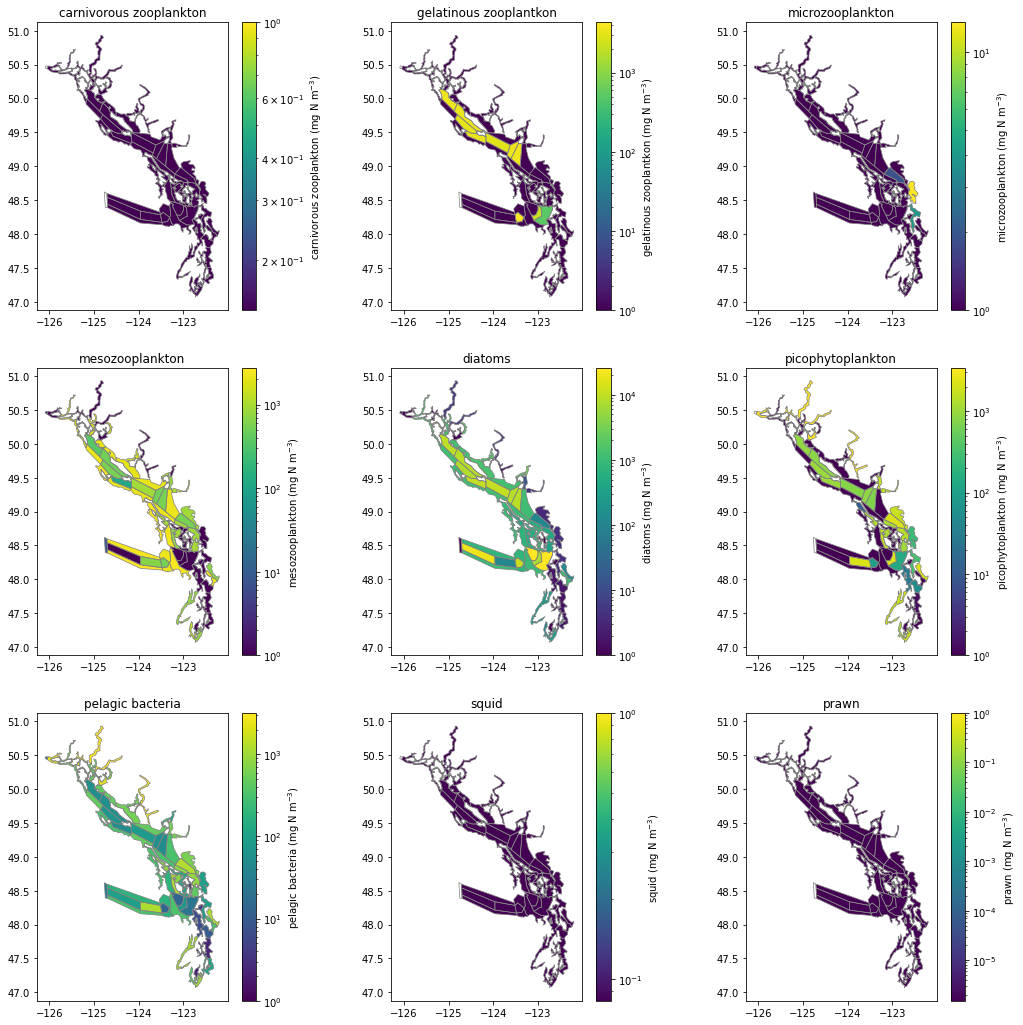

In [17]:
map_water_column(groups.planktonic)

### Benthos

In [18]:
def map_benthic(group, v_max=None, v_min=None):
  
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, height_ratios=[3, 3, 3])
    
    for scenario, label in zip(scenario_datasets, scenario_labels):

        for species in group:
            
            b_index = (list(group).index(species))

            if b_index < 3:
                position = 0, b_index
            elif b_index > 5: 
                position = 2, b_index-6
            else :
                position = 1, b_index-3

            dVar_s = scenario.variables[group[species] + '_N'][len(scenario.t)-5:len(scenario.t),:]
            scen = dVar_s.mean(axis=0)
            nm = str(label).split(sep = '_')

            # Add scenario data to Atlantis spatial data
            data_df['scen'] = scen
            data_df.loc[land_boxes, 'scen'] = 0
            ax = fig.add_subplot(gs[position])
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=-0.5) 
            ax = data_df.plot(column = 'scen', ax=ax, cax=cax, #norm=colors.LogNorm(vmin=1, vmax=data_df.scen.max()), #vmin=v_min, vmax=v_max vmin=0, vmax=20, cmap=cm.Greens,
                legend=True, legend_kwds={'label': species + ' (mg N m$^{-3}$)'},
                )
            ax.set_title(species, fontsize = 12)
            data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
            land_df.plot(ax=ax, color='white');

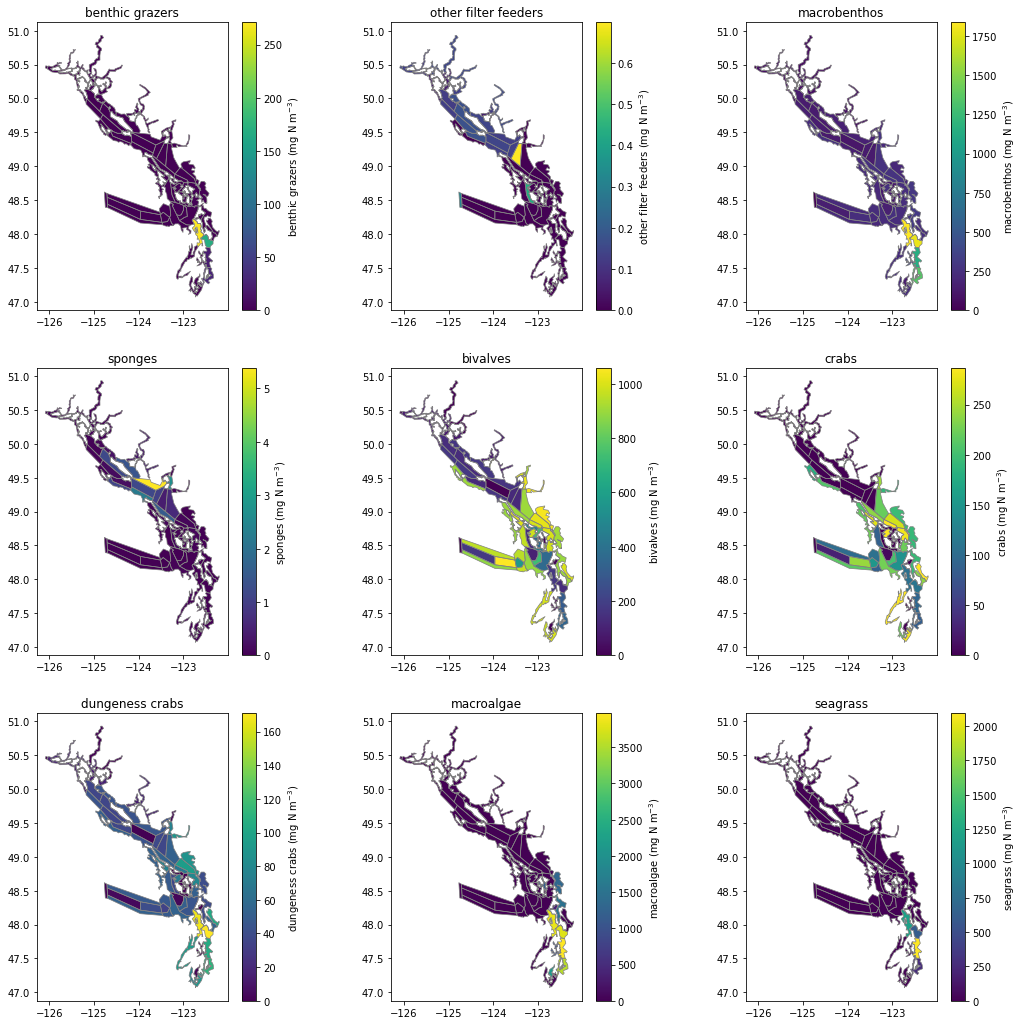

In [19]:
map_benthic(groups.benthos)

# Vertebrates

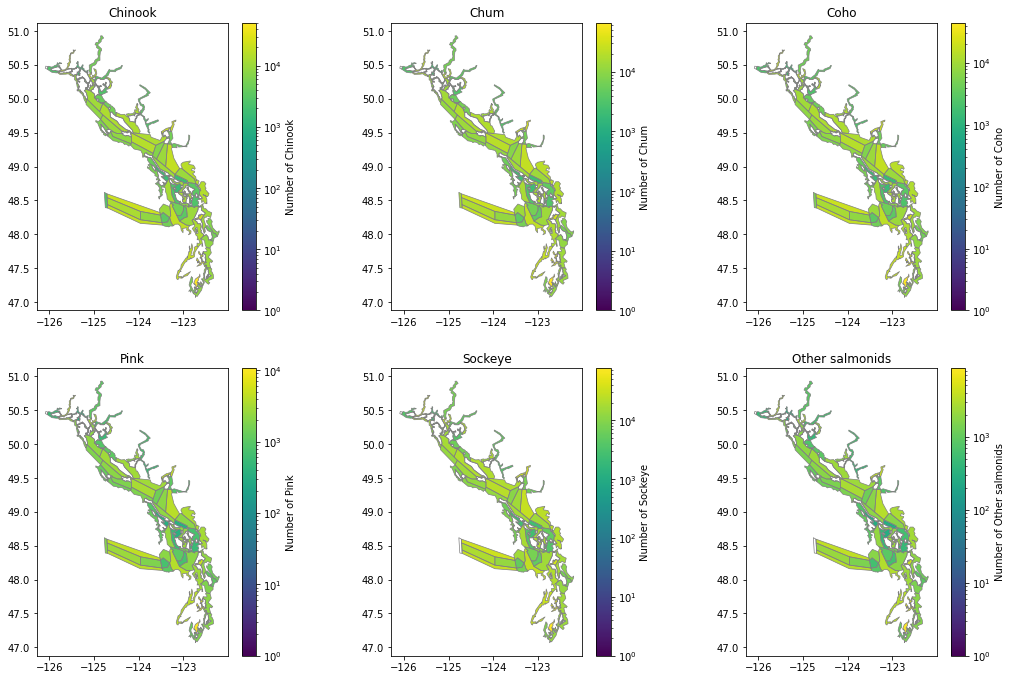

In [20]:
map_water_column_verts(groups.wild_salmon)

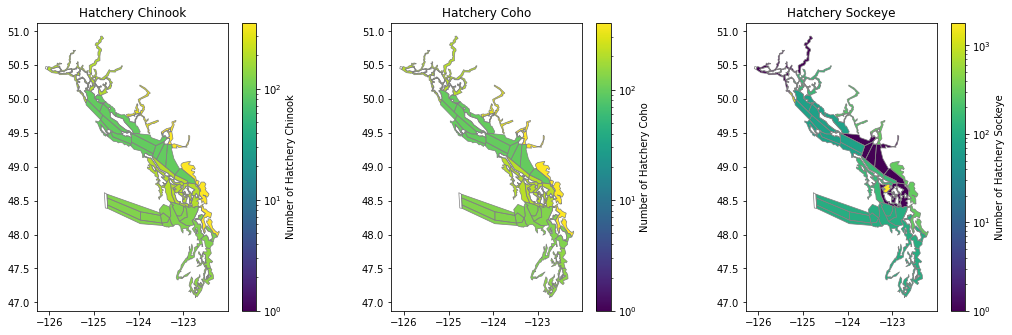

In [21]:
map_water_column_verts(groups.hatchery_salmon)

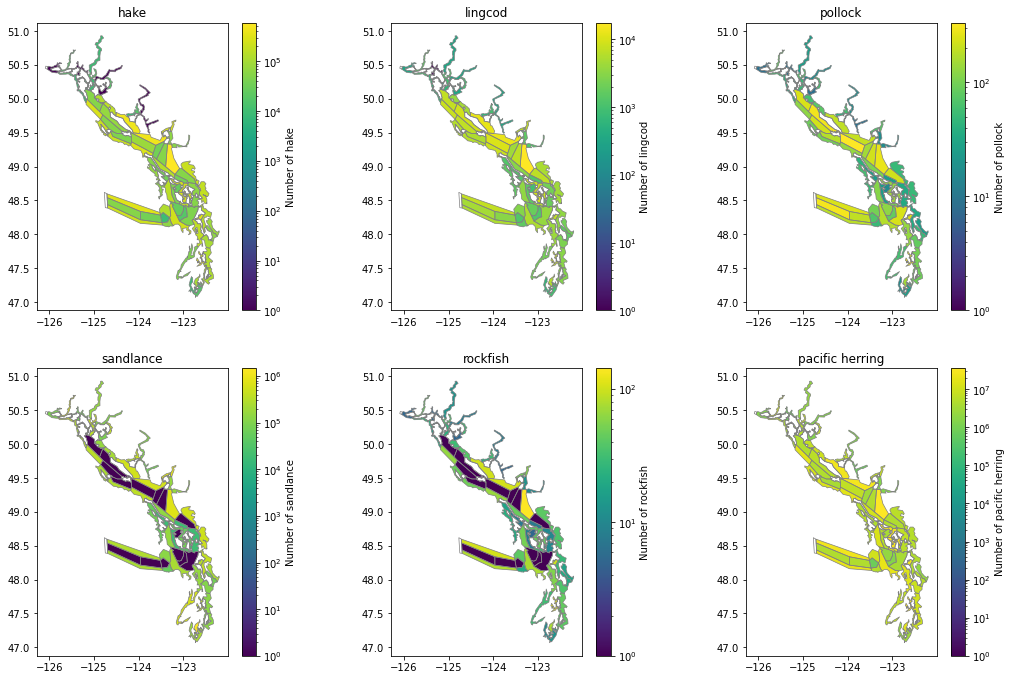

In [22]:
map_water_column_verts(groups.named_fish)

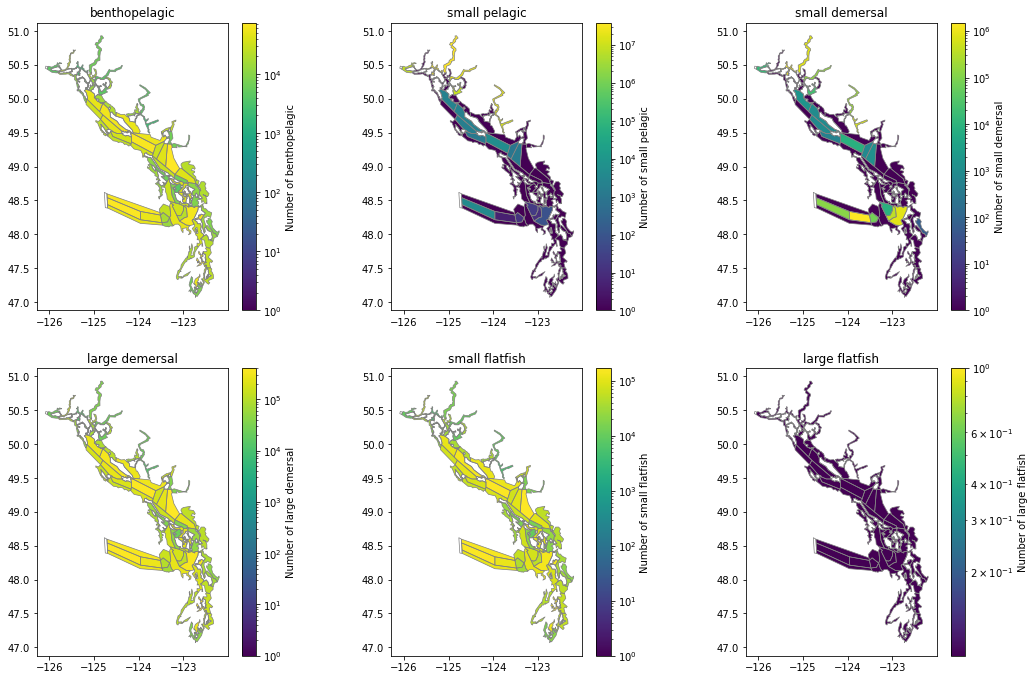

In [23]:
map_water_column_verts(groups.other_fish)

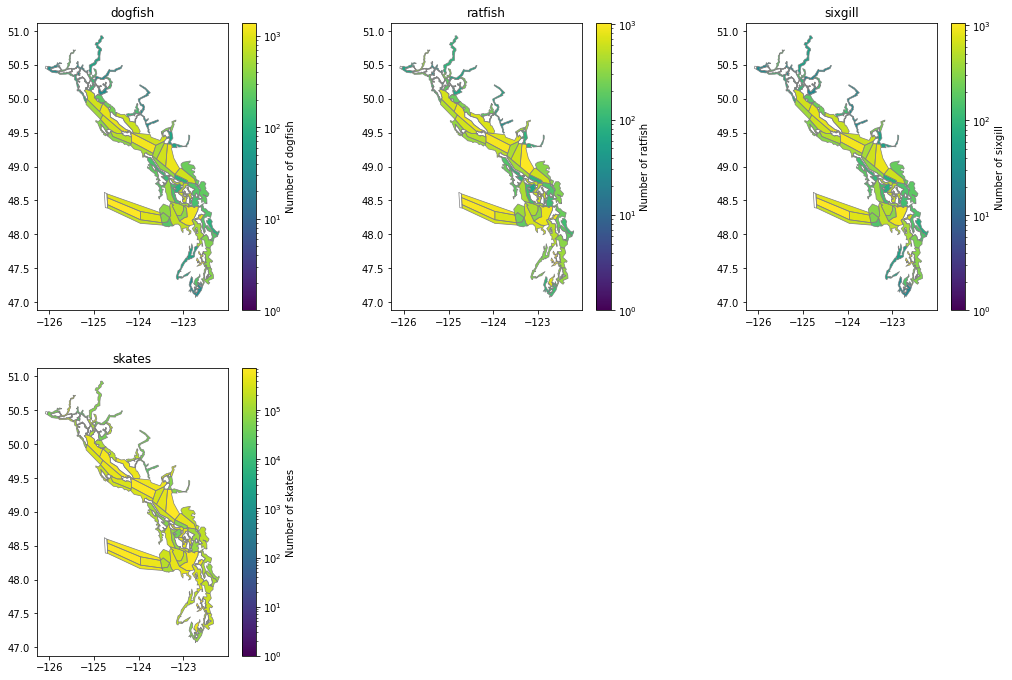

In [24]:
map_water_column_verts(groups.sharks)

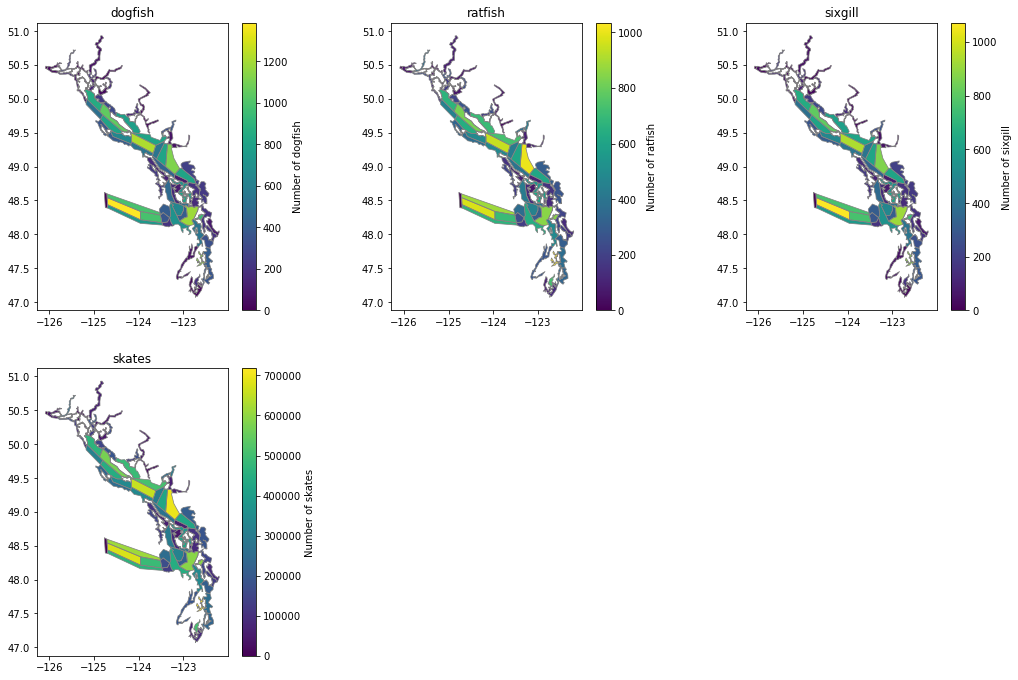

In [25]:
map_water_column_verts_linear(groups.sharks)

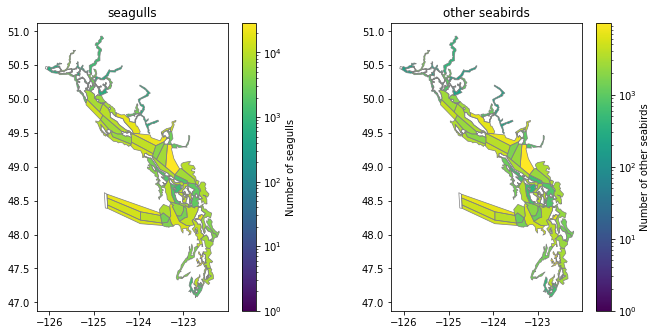

In [26]:
map_water_column_verts(groups.birds)

## Mammals

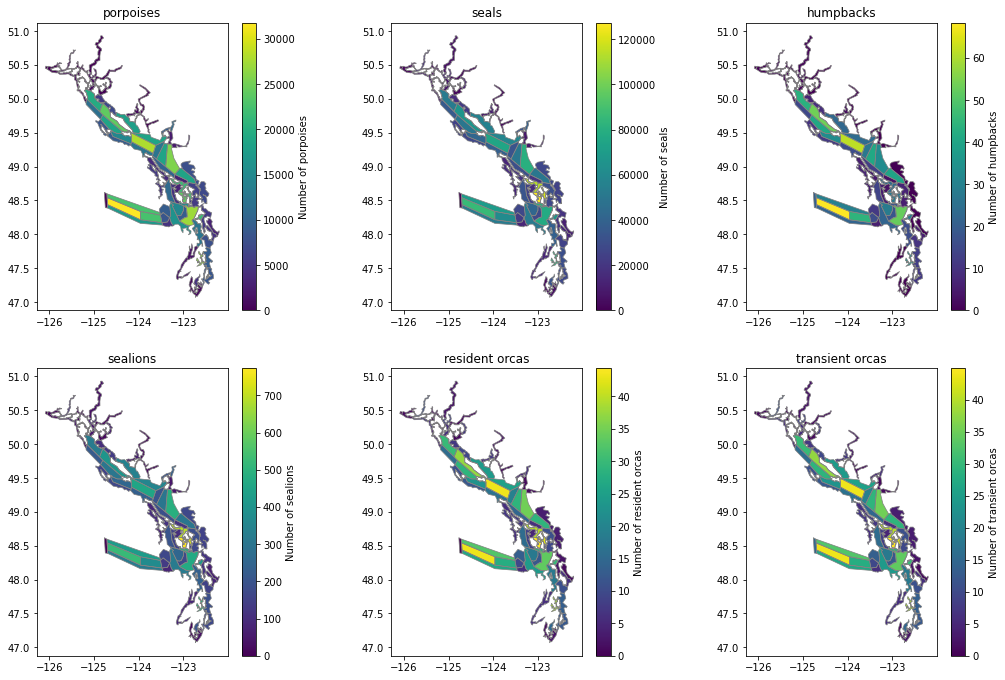

In [27]:
map_water_column_verts_linear(groups.mammals)